<div style='display:flex;'>
    <img src="https://apibab.pt/wp-content/uploads/2016/03/logo_ulht.png" width="200" height="200"/>
    <h1>Analysis of Alt-text use in mastodon.social by client</h1>
</div>

A project by [Cristal Rivera](https://linkedin.com/in/cristal-rivera-picado/) and [Tommaso Marmo](https://tommi.space/) to analyse the use of alt-text in [mastodon.social](https://mastodon.social/about), using [Stefan Bohacek](https://stefanbohacek.com/)’s <cite>[mastodon.social alt text use by client app](https://www.kaggle.com/datasets/fourtonfish/mastodon-social-alt-text-use-by-client-app)</cite> dataset, published on Kaggle under the [MIT license](https://www.mit.edu/~amini/LICENSE.md).

This analysis is being conducted as a group project for the [Introduction to Data Science](https://ois2.tlu.ee/tluois/subject/ULP6613-23265) course of the <cite>[Artificial Intelligence and Sustainable Societies](https://aissprogram.eu)</cite> master.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
''' Import and print dataset
Assigning the variable `original_data` too,
so that the original dataset can be preserved,
while we operate on the `data` variable.
'''
data = original_data = pd.read_csv('./fediverse-client-alt-text-data-2024-05-13.csv')

data

,client,status_count,descriptions_all_count,descriptions_all_percent,descriptions_some_count,descriptions_some_percent,descriptions_none_count,descriptions_none_percent
0,Web,8272,1438,17.383946,7,0.084623,6827,82.531431
1,dlvr.it,5806,1,0.017224,0,0.000000,5805,99.982776
2,Mastodon for Android,1894,270,14.255544,3,0.158395,1621,85.586061
3,unknown,1428,366,25.630252,1,0.070028,1061,74.299720
4,AboveMaidstoneBot,1339,0,0.000000,0,0.000000,1339,100.000000
...,...,...,...,...,...,...,...,...
261,socialbot,1,1,100.000000,0,0.000000,0,0.000000
262,PhonocasterMusicShare,1,0,0.000000,0,0.000000,1,100.000000
263,openvibe,1,0,0.000000,0,0.000000,1,100.000000
264,iflaapp,1,0,0.000000,0,0.000000,1,100.000000


## Data wrangling

In the first phase of our analysis, we will be analysing, cleaning, and structuring the data set. This will help us understand more specifically the kind of information our dataset contains, also by veryfing the accuracy and the quality of its data.

In [3]:
print(f'Confirm data type of the dataset: {type(original_data)}')

Confirm data type of the dataset: <class 'pandas.core.frame.DataFrame'>


### Information about the dataset

In this section, we will be retrieving general information about the dataset.

In [4]:
# Tuple with number of rows and number of columns
data_rows, data_columns = original_data.shape
# Integer that is the result of n of columns * n of rows
data_size = original_data.size

print(f'Number of rows:\t\t\t{data_rows}\nNumber of columns:\t\t{data_columns}\nData size (rows×columns):\t{data_size}')

Number of rows:			266
Number of columns:		8
Data size (rows×columns):	2128


The following code provides a summary of each column in the DataFrame, including:
- Data type
- Number of missing values
- Number of unique values
- Descriptive statistics for numerical columns using pandas’ `describe()`

Since the `client` column is a string, 

In [5]:
# Data type and count of missing values
summary = pd.DataFrame({
    'Data Type': original_data.dtypes,
    'Missing values?': any(original_data.isnull().sum())
})

# Descriptive statistics for numerical columns
numerical_summary = original_data.describe()
summary = summary.merge(numerical_summary.T, left_index=True, right_index=True, how='left')

summary

,Data Type,Missing values?,count,mean,std,min,25%,50%,75%,max
client,object,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status_count,int64,False,266.0,112.240602,643.625189,1.0,2.0,8.0,39.75,8272.000000
descriptions_all_count,int64,False,266.0,21.473684,105.282555,0.0,0.0,0.0,4.00,1438.000000
descriptions_all_percent,float64,False,266.0,36.290411,45.079671,0.0,0.0,0.0,100.00,100.000000
descriptions_some_count,int64,False,266.0,0.093985,0.622382,0.0,0.0,0.0,0.00,7.000000
descriptions_some_percent,float64,False,266.0,0.060461,0.527118,0.0,0.0,0.0,0.00,7.142857
descriptions_none_count,int64,False,266.0,90.672932,568.477040,0.0,0.0,2.0,20.00,6827.000000
descriptions_none_percent,float64,False,266.0,63.649128,45.113843,0.0,0.0,100.0,100.00,100.000000


**Note**: Even though it is a serie of strings with no missing values, pandas returns `object` as the data type for `client`, because it assigns the less strict type possible, by default. At a later moment, we will arbitrarily instruct pandas to treat all `client`s as strings, both for consistency and for memory optimization purposes.

In [6]:
print(f'Are there any duplicated clients? {any(original_data['client'].duplicated())}')

Are there any duplicated clients? False


### Naming and understanding data fields

All columns correspond to relevant data, and to achieve this we will be going through each column, one by one, to understand its meaning and rename it in more explicatory name.

**Note**: since we are now *modifying* the dataset, we will be using the `data` variable, and not the `original_data` one.

In [7]:
data = data.rename(columns={
    'status_count': 'posts',
    'descriptions_all_count': 'atxt_yes',
    'descriptions_all_percent': 'atxt_yes_pct',
    'descriptions_some_count': 'atxt_some',
    'descriptions_some_percent': 'atxt_some_pct',
    'descriptions_none_count': 'atxt_no',
    'descriptions_none_percent': 'atxt_no_pct'
})

| variable | meaning |
|--- |--- |
| `client` | Name of the client the posts come from. |
| `posts`| Total number of posts containing images for that client. |
| `atxt_yes` | Number of posts containing alt text in *all* images. |
| `atxt_yes_pct` | The percentage of `atxt_yes` in relation to `posts`. |
| `atxt_some` | Number of posts containing alt text in *some* images. |
| `atxt_some_pct` | The percentage of `atxt_some` in relation to `posts`. |
| `atxt_no` | Number of posts containing *no* alt text in *any* images. |
| `atxt_no_pct` | The percentage of `atxt_no` in relation to `posts`. |

#### Notes

- All the posts under analysis come *exclusively* from the [mastodon.social](https://mastodon.social) Fediverse instance.
- For the sake of simplicity, columns’ labels have been renamed using shorter variables.

### Optimize the dataset for analysis

In [8]:
# Sort clients by status_count
data = data.sort_values('posts',ascending=False)

In [9]:
# Consider all client names as strings (they were objects)
data['client'] = data['client'].astype('string')
print(f'Client data type: {data['client'].dtype}')

Client data type: string


In [10]:
# Round percentage values to the first decimal digit
data['atxt_yes_pct'] = data['atxt_yes_pct'].round(1)
data['atxt_some_pct'] = data['atxt_some_pct'].round(1)
data['atxt_no_pct'] = data['atxt_no_pct'].round(1)

### Exclude posts from unknown client(s)

Based on our initial observation, we recognize that the third most used client is labelled as “unknown”. Since our project stongly focuses on the impact of specific clients on the use of alt text, **we arbitrarily choose to drop (exclude) from the dataset posts that come from an undefined client**.

In [11]:
data = data.drop(data[data['client'] == 'unknown'].index)

### Find the mode

By calculating the mode, we intend to discover **the most frequent total number of posts clients have**.

In [12]:
mode = data['posts'].mode()[0] # Using [0] to get only the first mode, as this function can return multiple values.

We can observe that the majority of clients has only one posts. We will save the `mode`=1 value to use it at a later stage of the analysis.

## Data exploration

Since we sorted the dataset by the number of posts published from each client, we use the following function to see the five most used clients.

In [13]:
# 5 is the default value for head()
data.head()

,client,posts,atxt_yes,atxt_yes_pct,atxt_some,atxt_some_pct,atxt_no,atxt_no_pct
0,Web,8272,1438,17.4,7,0.1,6827,82.5
1,dlvr.it,5806,1,0.0,0,0.0,5805,100.0
2,Mastodon for Android,1894,270,14.3,3,0.2,1621,85.6
4,AboveMaidstoneBot,1339,0,0.0,0,0.0,1339,100.0
5,Mastodon for iOS,1052,227,21.6,1,0.1,824,78.3


Between `2` and `4`, we can observe a gap in the index number, since posts published from unknown clients occupied that position.

### General analysis

Analyzing general alt text use, independently of the client.

In [14]:
# The dataset already includes percentages. Let’s calculate and verify them.
posts_tot = data['posts'].sum()
atxt_yes_tot = data['atxt_yes'].sum()
atxt_some_tot = data['atxt_some'].sum()
atxt_no_tot = data['atxt_no'].sum()

atxt_yes_tot_pct = round(atxt_yes_tot / posts_tot * 100, 1)
atxt_some_tot_pct = round(atxt_some_tot / posts_tot * 100, 1)
atxt_no_tot_pct = round(atxt_no_tot / posts_tot * 100, 1)

if posts_tot == atxt_yes_tot + atxt_some_tot + atxt_no_tot:
    print('Posts count is matching!')
else:
    print('Something is wrong in the dataset. Please revise the number of posts!')

Posts count is matching!


In [15]:
# The dataset already includes percentages. Let’s calculate and verify them.
if data['atxt_yes_pct'].equals(round(data['atxt_yes']/data['posts']*100, 1)) and data['atxt_no_pct'].equals(round(data['atxt_no']/data['posts']*100, 1)):
    print('The percentages in the dataset are accurate!')

The percentages in the dataset are accurate!


In [16]:
print(f'''
Total number of posts under analysis: {posts_tot}
    of which {atxt_yes_tot} ({atxt_yes_tot_pct}%) contain an alt-text for all images,
    {atxt_some_tot} ({atxt_some_tot_pct}%) for some,
    and {atxt_no_tot} ({atxt_no_tot_pct}%) have no alt-text at all.
''')


Total number of posts under analysis: 28428
    of which 5346 (18.8%) contain an alt-text for all images,
    24 (0.1%) for some,
    and 23058 (81.1%) have no alt-text at all.



The usage of alt text for some images only is very negligible (0.1%), therefore we are arbitrarily deciding to **drop (exclude) this column from the dataset**.

In [17]:
# Subtracting from the total of posts the ones that only have alt text for some images only
data['posts'] = data['posts'] - data['atxt_some']

# Remove columns related to some alt text
data.pop('atxt_some')
data.pop('atxt_some_pct')

0      0.1
1      0.0
2      0.2
4      0.0
5      0.1
      ... 
261    0.0
262    0.0
263    0.0
264    0.0
265    0.0
Name: atxt_some_pct, Length: 265, dtype: float64

([<matplotlib.patches.Wedge at 0x7fd9b9a60ad0>,
 [Text(0.913245498990903, 0.6131742481325002, 'Alt-text for all images'),
  Text(-0.9132456281256516, -0.6131740558025791, 'No alt-text')],
 [Text(0.49813390854049244, 0.3344586807995455, '18.8%'),
  Text(-0.49813397897762807, -0.3344585758923158, '81.2%')])

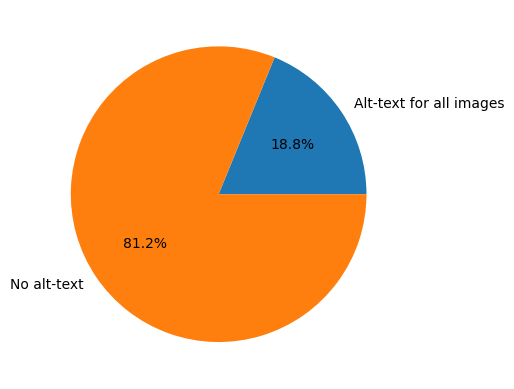

In [18]:
posts_pie = [atxt_yes_tot, atxt_no_tot]
labels_pie = ['Alt-text for all images', 'No alt-text']

fig, ax = plt.subplots()
ax.pie(posts_pie, labels=labels_pie, autopct='%1.1f%%')

### Analyzing client data

In this section, we will analyze the total number of posts per client. During the initial data exploration, we observed that many clients have only one post. Our objective is to explore how many clients fall into this category and determine whether it would be beneficial to treat this group differently to reduce potential noise in the dataset.

In [19]:
##Count how many posts_counts by client

#select columns we want to analyze
data_selected = data[['client', 'posts']].head(20) # view only the first 20 clients to get a general overview of how they behave
data_selected

,client,posts
0,Web,8265
1,dlvr.it,5806
2,Mastodon for Android,1891
4,AboveMaidstoneBot,1339
5,Mastodon for iOS,1051
6,Buffer,794
7,Indie 102.3 Playlist Bot,571
8,Tusky,503
9,KUVO Playlist Bot,365
10,The Colorado Sound Playlist Bot,361


<module 'matplotlib.pyplot' from '/home/tommi/dev/mastodon-alt-text/.venv/lib64/python3.13/site-packages/matplotlib/pyplot.py'>

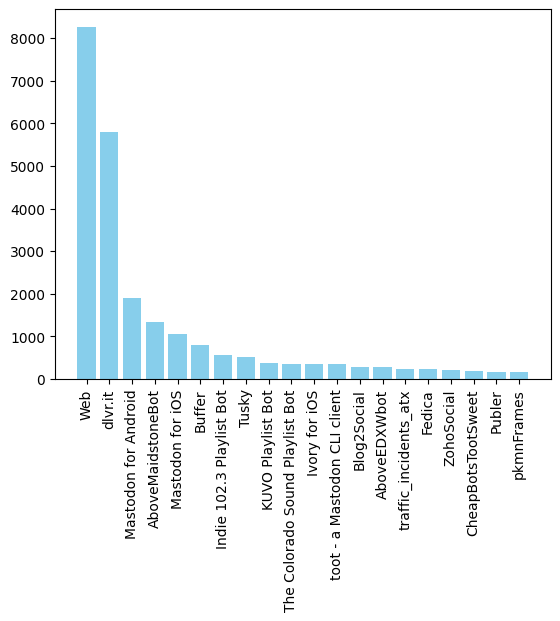

In [20]:
#barplot: review top 20 clients with more posts
plt.bar(data_selected['client'],data_selected['posts'],color = 'skyblue')
plt.xticks(rotation=90)
plt

The bar plot reveals that, among the top 20 clients, the Web client has the highest number of posts (8272), while pkmnFrames has only 163 posts. This highlights a significant disparity in the number of posts even within the top 20 clients, showcasing the wide variation in engagement levels between the extremes.

In [21]:
# we want to know how many clients from the 266 clients have only one post, we will filter the data where posts=1
data_clients_mode = data[data['posts'] == mode]
data_clients_mode

,client,posts,atxt_yes,atxt_yes_pct,atxt_no,atxt_no_pct
243,Mastoot,1,0,0.0,1,100.0
242,AEGIS FS Poster App,1,0,0.0,1,100.0
240,Epic News Canada,1,0,0.0,1,100.0
241,PixelDroid,1,0,0.0,1,100.0
233,Sanweb,1,0,0.0,1,100.0
232,Rodent,1,0,0.0,1,100.0
239,UnitedSpaceCats,1,1,100.0,0,0.0
238,tgbot-mastodon-sync,1,0,0.0,1,100.0
237,AutstralianArtGallery_clientcred.secret,1,1,100.0,0,0.0
236,TweeseCake,1,1,100.0,0,0.0


In [22]:
# count how many clients have only one post
clients_mode = len(data_clients_mode) #is 52, meaning that 52 are the clients with one post
len(data) # 266 from original data set

265

In [23]:
clients_mode_pct = (clients_mode/len(data))*100
print(f'Around {round(clients_mode_pct,1)}% of the clients in the data set have only one post')

Around 19.6% of the clients in the data set have only one post


The `posts_count` analysis groups the number of posts and counts how many clients fall into each group. For example, there are 52 clients with only one post, 31 clients with two posts, and so on. This distribution clearly indicates that a significant portion of clients have only one post. Such a notable concentration suggests it might be more meaningful to treat these single-post clients as a separate cluster and analyze them independently to reduce potential noise in the dataset and gain more targeted insights.

In [24]:
'''
Comparing this with the entire data set:
we want to count how many clients have the same number of posts.
'''
posts = data['posts'].value_counts().sort_index()
# Filter out post counts with less than 10 clients
posts = posts[posts >= 10]
posts

posts
1    52
2    31
3    18
4    14
9    10
Name: count, dtype: int64

Text(0.5, 1.0, 'Frequency of total posts counted by client')

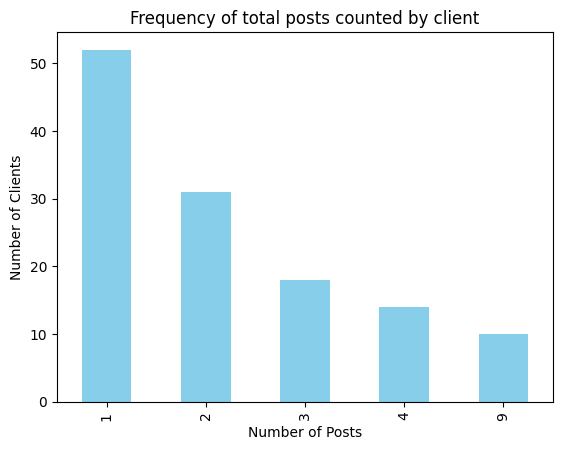

In [25]:
# Create a bar plot
plt.figure()
posts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Number of Posts')
plt.ylabel('Number of Clients')
plt.title('Frequency of total posts counted by client')